**Check GPU RAM for the current Colab Runtime**


In [1]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install -q gputil
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
    process = psutil.Process(os.getpid())
    print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
    print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm() 

Gen RAM Free: 26.3 GB  | Proc size: 159.0 MB
GPU RAM Free: 11441MB | Used: 0MB | Util   0% | Total 11441MB


**Import the Relvant Libraries**

In [0]:
try:
    # %tensorflow_version only exists in Colab.
    %tensorflow_version 2.x
    # Load the TensorBoard notebook extension
    %load_ext tensorboard   
except Exception:
  pass

import tensorflow as tf
from tensorflow import keras
from tensorboard.plugins.hparams import api as hp

In [3]:
from sklearn.preprocessing import LabelBinarizer, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import imgaug.augmenters as iaa
import matplotlib.pyplot as plt
from imutils import paths
import seaborn as sns
import imgaug as aug
import pandas as pd
import numpy as np
import datetime
import h5py
import cv2
import os

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Helper Functions
def show_image(img):
    '''
    Quick display of image in grayscale 
    '''
    if type(img) == 'str':
        img = plt.imread(img)
    plt.imshow(img, cmap = 'gray')
    plt.title('Example X-Ray scan')
    plt.grid(False)
    plt.axis('off')
    plt.show()

Clone dataset repository from Github


In [20]:
!git clone https://github.com/rekalantar/covid19_detector

Cloning into 'covid19_detector'...
remote: Enumerating objects: 2397, done.
remote: Total 2397 (delta 0), reused 0 (delta 0), pack-reused 2397
Receiving objects: 100% (2397/2397), 947.45 MiB | 49.67 MiB/s, done.
Resolving deltas: 100% (50/50), done.
Checking out files: 100% (2315/2315), done.


Read Nomral vs Covid-19 images and one-hot encod the labels


[INFO] loading images...

[INFO] creating a DataFrame...
                                               image     label
0  covid19_detector/DATASET/0-NORMAL/00027874_000...  0-NORMAL
1  covid19_detector/DATASET/1-COVID/covid-19-infe...   1-COVID
2  covid19_detector/DATASET/0-NORMAL/00012406_001...  0-NORMAL
3  covid19_detector/DATASET/0-NORMAL/00001821_000...  0-NORMAL
4  covid19_detector/DATASET/0-NORMAL/00022830_001...  0-NORMAL
5  covid19_detector/DATASET/0-NORMAL/00015854_002...  0-NORMAL
6  covid19_detector/DATASET/1-COVID/1-s2.0-S16841...   1-COVID
7  covid19_detector/DATASET/0-NORMAL/00025888_001...  0-NORMAL
8  covid19_detector/DATASET/0-NORMAL/00002054_002...  0-NORMAL
9  covid19_detector/DATASET/0-NORMAL/00012932_000...  0-NORMAL


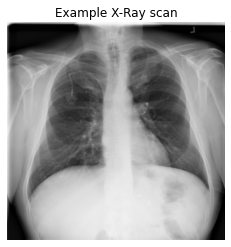


[INFO] one-hot encoding...
	Example scan label: 0-NORMAL
	One-hot encoded label:  0

[INFO] updating data DataFrame...
                                               image  label
0  covid19_detector/DATASET/0-NORMAL/00027874_000...      0
1  covid19_detector/DATASET/1-COVID/covid-19-infe...      1
2  covid19_detector/DATASET/0-NORMAL/00012406_001...      0
3  covid19_detector/DATASET/0-NORMAL/00001821_000...      0
4  covid19_detector/DATASET/0-NORMAL/00022830_001...      0
5  covid19_detector/DATASET/0-NORMAL/00015854_002...      0
6  covid19_detector/DATASET/1-COVID/1-s2.0-S16841...      1
7  covid19_detector/DATASET/0-NORMAL/00025888_001...      0
8  covid19_detector/DATASET/0-NORMAL/00002054_002...      0
9  covid19_detector/DATASET/0-NORMAL/00012932_000...      0


In [23]:
dataset_path = 'covid19_detector/DATASET'

# Read all files from path
print("[INFO] loading images...")
imagePaths = list(paths.list_images(dataset_path))

data = []

# select number of classes to be loaded for Normal, Bacterial Pneumonia and Viral Pneumonia patients 
num_normal = 362

n = 0 #initialize all 3 counters to limit the number of images loaded 
for imagePath in imagePaths:
    # extract the class label from the filename
    label = imagePath.split(os.path.sep)[-2]

    if label == '0-NORMAL' and n < num_normal:
      data.append((imagePath,label))
      n += 1

    elif label == '1-COVID':
      data.append((imagePath,label))

print('\n[INFO] creating a DataFrame...')
# Get a pandas dataframe from the data we have in our list 
data = pd.DataFrame(data, columns=['image', 'label'],index=None)

# Shuffle the data 
data = data.sample(frac=1.).reset_index(drop=True)
print(data.head(10))

tmp_img = plt.imread(data["image"][0])
show_image(tmp_img)
del tmp_img

# perform one-hot encoding on the labels
print('\n[INFO] one-hot encoding...')
print('\tExample scan label:', data["label"][0])

data["label"] = LabelEncoder().fit_transform(data["label"])
print('\tOne-hot encoded label: ',data["label"][0])
print('\n[INFO] updating data DataFrame...')
print(data.head(10))

Visualise example X-ray scans


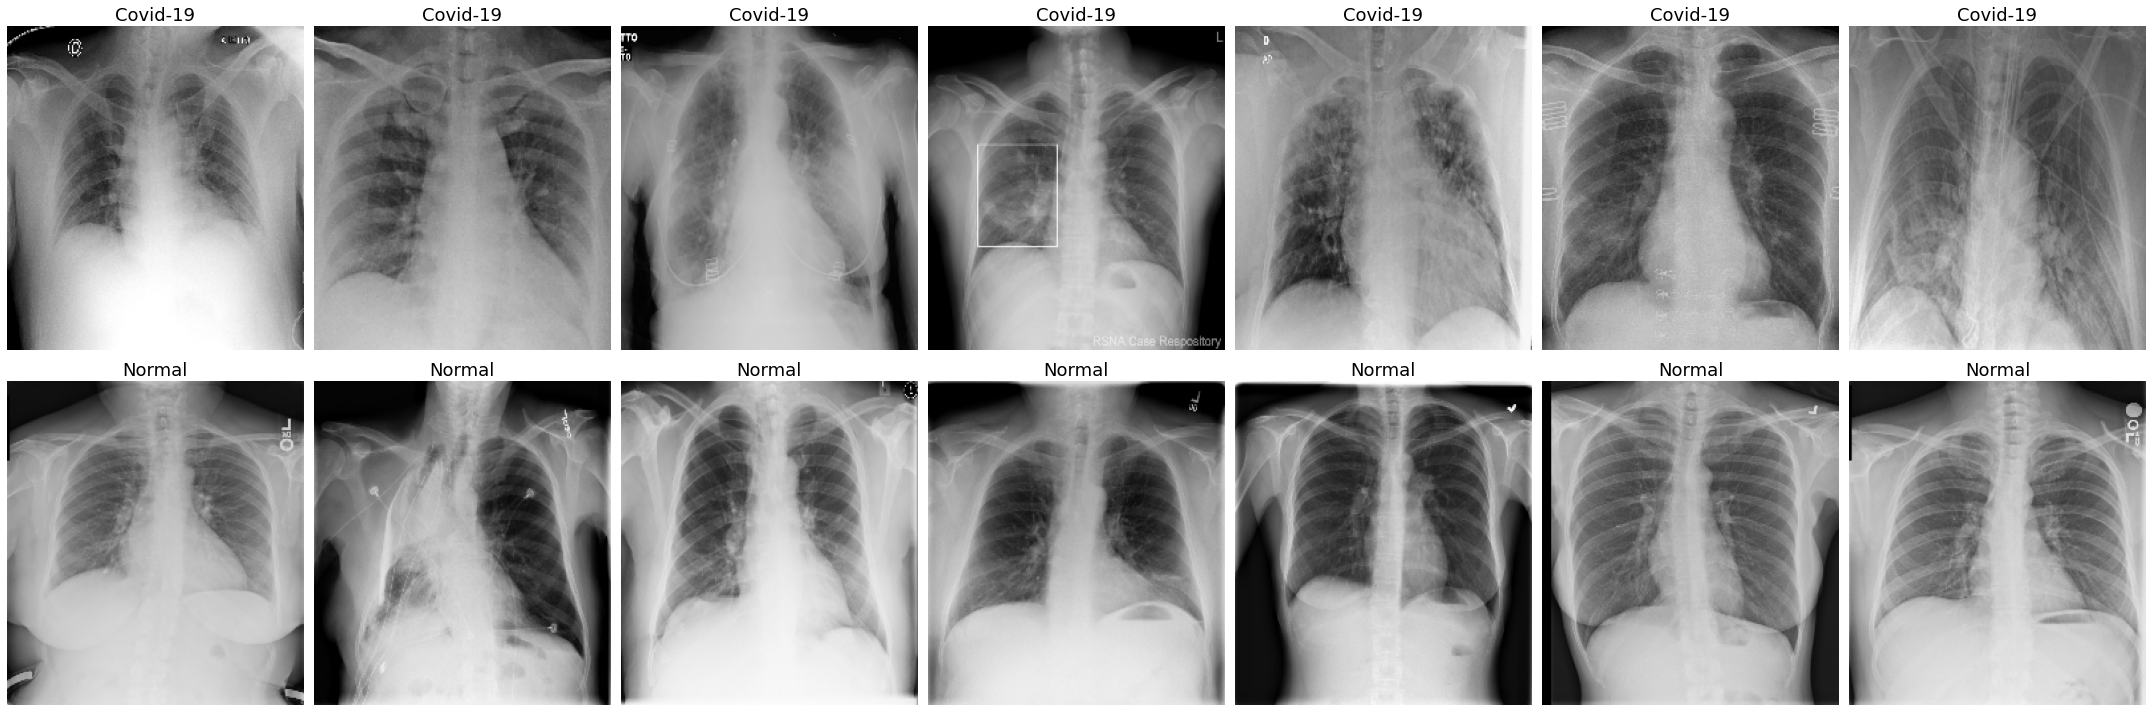

In [24]:
# select the number of sampels to be plotted for each class
sample_num = 7
normal_samples = (data[data['label']==0]['image'].iloc[30:30+sample_num]).tolist()
covid_samples = (data[data['label']==1]['image'].iloc[5:5+sample_num]).tolist()

samples = covid_samples + normal_samples
del covid_samples, normal_samples

color = 'black'

# Plot the data 
f, ax = plt.subplots(2,sample_num, figsize=(30,10))
for i in range(sample_num*2):
    img = cv2.imread(samples[i])
    img = cv2.resize(img, (224, 224))
    if i<sample_num:
        ax[0, i%sample_num].imshow(img, cmap='gray')
        ax[0, i%sample_num].set_title("Covid-19", fontsize=18, color = color)
    else:
        ax[1, i%sample_num].imshow(img, cmap='gray')
        ax[1, i%sample_num].set_title("Normal", fontsize=18, color = color)

    ax[i//sample_num, i%sample_num].axis('off')
    ax[i//sample_num, i%sample_num].set_aspect('auto')

plt.tight_layout()
plt.show()


Select training, validation and testing data split

In [0]:
train_data, test_data = train_test_split(data, test_size=0.20,shuffle=True)
train_data, valid_data = train_test_split(train_data, test_size=0.20)

print('\nNumber of training pairs: ', len(train_data))
print('Number of validation pairs: ', len(valid_data))
print('Number of testing pairs: ', len(test_data))


Number of training pairs:  347
Number of validation pairs:  87
Number of testing pairs:  109


In [0]:
data['label'].value_counts()

0    362
1    181
Name: label, dtype: int64

	----- Entire Dataset ------
	  [362 181]

-- Train Set -- -- Validation Set -- -- Test Set --
 [230 117] 	      [56 31] 	  [76 33] 




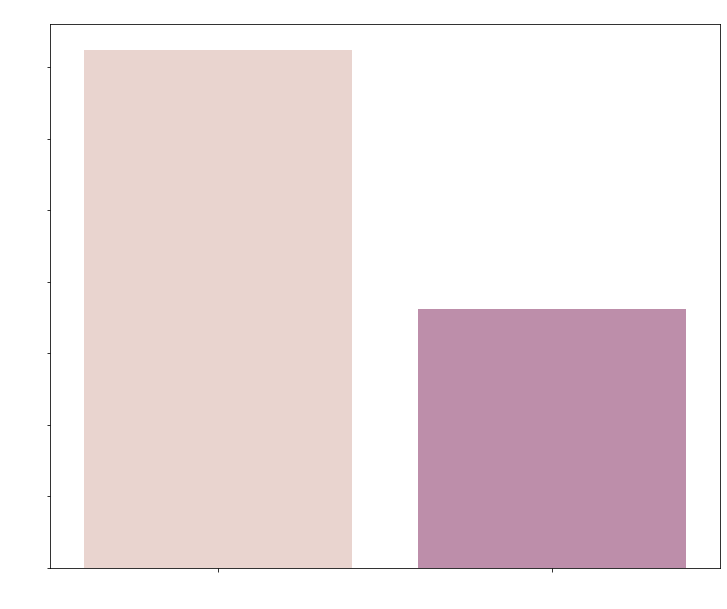

In [0]:
# Get the counts for each class
cases_count = data['label'].value_counts()
print('\t----- Entire Dataset ------')
print('\t ', cases_count.ravel())

cases_count_tr = train_data['label'].value_counts()
cases_count_val = valid_data['label'].value_counts()
cases_count_tst = test_data['label'].value_counts()
print('\n-- Train Set -- -- Validation Set -- -- Test Set --')
print('', cases_count_tr.ravel(),'\t     ',cases_count_val.ravel(), '\t ', cases_count_tst.ravel(), '\n\n')

# Plot the results 
plt.figure(figsize=(12,10))
sns.barplot(x=cases_count.index, y= cases_count.values, palette=sns.cubehelix_palette(4, start=2.5, rot=0.6))
plt.title('Frequency of Each Class in the Dataset', fontsize=14, color='w') #remove color = white if not in dark mode!
plt.xlabel('Case type', fontsize=12, color='w')
plt.ylabel('Count', fontsize=12, color='w')
plt.xticks(range(len(cases_count.index)), ['Normal (0)', 'Covid-19 (1)'], color='w')
plt.yticks(color='w')
plt.show()

In [0]:
def get_arrays(df):
    print('[INFO] retreiving images from path...')
    images, labels = [], []

    img_paths = df.iloc[:,0].values # extract image paths from DataFrame
    labels_ = df.iloc[:,1].values # extract labels from DataFrame

    for i,path in enumerate(img_paths):
        # load the image, swap color channels, and resize it to be a fixed 224x224 pixels while ignoring aspect ratio
        image = cv2.imread(path)

        # check if it's grayscale
        if image.shape[2]==1:
            print(image.shape[2])
            image = np.dstack([image, image, image])

        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, (512, 512))
        image = image / 255.0 # Normalize images to range [0,1]
        # print('pre: ', labels_[i])
        encoded_label = tf.keras.utils.to_categorical(labels_[i], num_classes=2)
        # print('encoded: ',encoded_label )
        images.append(image)
        labels.append(encoded_label)

    return np.array(images), np.array(labels)

In [0]:
trainX, trainY = get_arrays(train_data)
validX, validY = get_arrays(valid_data)
testX, testY = get_arrays(test_data)

[INFO] retreiving images from path...
[INFO] retreiving images from path...
[INFO] retreiving images from path...


In [0]:
# calculating class weights from trainset for class imabalance
print('[INFO] calculating class weights...')
print(cases_count_tr)
covid_pneumonia_count = cases_count_tr.ravel()[1]
normal_count = cases_count_tr.ravel()[0]

class_weights = {0: 1.0, 1: normal_count/covid_pneumonia_count} 

print('\nclass weights: ', class_weights) 

[INFO] calculating class weights...
0    230
1    117
Name: label, dtype: int64

class weights:  {0: 1.0, 1: 1.9658119658119657}


Build our model on top of pre-trained VGG-19 model


In [0]:
def build_model(baseModel):

      # Make all pre-trained layers non-trainable 
      for layer in baseModel.layers[:-3]:
          layer.trainable = False

      # Add trainable fully-connected (FC) layers for predictions
      newModel = baseModel.output
      newModel = tf.keras.layers.AveragePooling2D(pool_size=(4, 4))(newModel)
      newModel = tf.keras.layers.Flatten(name="flatten")(newModel)
      newModel = tf.keras.layers.Dense(256, activation="relu")(newModel)
      newModel = tf.keras.layers.Dropout(0.5)(newModel)
      newModel = tf.keras.layers.Dense(2, activation="softmax")(newModel)

      # Stack the FC layers on top of VGG19 model
      model = tf.keras.models.Model(inputs=baseModel.input, outputs=newModel, name='Covid19_Detector')

      return model

baseModel = classifier = tf.keras.applications.VGG19(weights="imagenet", include_top=False,
            input_tensor = tf.keras.layers.Input(shape=img_size))
model = build_model(baseModel)

model.compile(loss=tf.keras.losses.binary_crossentropy, optimizer='adam', metrics=["accuracy"])

# initialize the training data augmentation object
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    # rescale= 1 / 255.0,
    rotation_range=15,
    zoom_range=0.05,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.05,
    fill_mode="nearest")

  
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator()


early_stopping = tf.keras.callbacks.EarlyStopping(
monitor='val_accuracy', 
verbose=1,
patience=15,
mode='max',
restore_best_weights=True
)

reduce_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.25, patience=3, verbose=0, 
                                                                    mode='auto', min_delta=0.0001, cooldown=0, min_lr=0)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint('VGG19_weights.h5', 
                                                      monitor='val_accuracy', verbose=0, save_best_only=True, 
                                                      save_weights_only=True, mode='max')


callbacks = [early_stopping, reduce_on_plateau, model_checkpoint]

results = model.fit(
    train_datagen.flow(trainX, trainY, batch_size=batch_size),
    steps_per_epoch=len(trainX) // batch_size,
    validation_data=valid_datagen.flow(validX, validY, batch_size=batch_size),
    validation_steps=len(validX) // batch_size,
    class_weight = class_weights,
    epochs=epochs,
    callbacks=callbacks
)

Analyse Results from the Test Set

In [0]:
# Make predictions on the testing set
print("[INFO] evaluating network...")
batch_size = 15
predIdxs = model.predict(testX, batch_size=batch_size)
print('Number of test scans: ', len(testX))
print('Predicted class probabilities:')
print()

for n in range(len(predIdxs)):
    my_formatted_list = ['%.2f' % elem for elem in predIdxs[n]]
    print(f'{n}:  ', *my_formatted_list)

# Find the predicted labels 
predIdxs = np.argmax(predIdxs, axis=1)
print('\nPredicted outcome (Covid=1, Normal=0):')
print(predIdxs)
print('Ground-truth outcome:')
# print(testY)
trueIdxs = np.argmax(testY, axis=1)
print(trueIdxs)

[INFO] evaluating network...
Number of test scans:  109
Predicted class probabilities:

0:   0.01 0.99
1:   0.00 1.00
2:   1.00 0.00
3:   1.00 0.00
4:   0.00 1.00
5:   0.01 0.99
6:   1.00 0.00
7:   1.00 0.00
8:   1.00 0.00
9:   0.00 1.00
10:   1.00 0.00
11:   0.00 1.00
12:   0.00 1.00
13:   0.00 1.00
14:   1.00 0.00
15:   0.00 1.00
16:   1.00 0.00
17:   1.00 0.00
18:   1.00 0.00
19:   1.00 0.00
20:   1.00 0.00
21:   0.99 0.01
22:   1.00 0.00
23:   1.00 0.00
24:   0.00 1.00
25:   0.00 1.00
26:   0.95 0.05
27:   0.00 1.00
28:   1.00 0.00
29:   0.95 0.05
30:   1.00 0.00
31:   1.00 0.00
32:   1.00 0.00
33:   0.95 0.05
34:   0.00 1.00
35:   1.00 0.00
36:   1.00 0.00
37:   0.99 0.01
38:   1.00 0.00
39:   0.01 0.99
40:   1.00 0.00
41:   1.00 0.00
42:   1.00 0.00
43:   1.00 0.00
44:   0.00 1.00
45:   0.00 1.00
46:   1.00 0.00
47:   0.56 0.44
48:   0.00 1.00
49:   1.00 0.00
50:   1.00 0.00
51:   1.00 0.00
52:   1.00 0.00
53:   0.00 1.00
54:   0.00 1.00
55:   1.00 0.00
56:   0.75 0.25
57:   1.00

Loss/Accuracy Curve

In [0]:
N = len(results.history["loss"])
plt.style.use("ggplot")
plt.figure(figsize = (20,10))
plt.plot(np.arange(0, N), results.history["loss"], label="train_loss", color = 'firebrick')
plt.plot(np.arange(0, N), results.history["val_loss"], label="val_loss", color = 'salmon')
plt.plot(np.arange(0, N), results.history["accuracy"], label="train_acc", color = 'teal')
plt.plot(np.arange(0, N), results.history["val_accuracy"], label="val_acc",color = 'cadetblue')
plt.plot( np.argmax(results.history["val_accuracy"]), np.max(results.history["val_accuracy"]), marker="x", color="r", label="best model")
plt.title("Training Loss and Accuracy on COVID-19 Dataset")
plt.xlabel("Epochs")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right", fontsize=15)
plt.savefig('loss_curve.pdf', format='pdf')
plt.show()

compute the confusion matrix and and use it to derive the raw accuracy, sensitivity, and specificity

In [0]:
from matplotlib.font_manager import FontProperties

def plot_cm(labels, predictions):
    '''
    Plot the confusion matrix
    '''

    font = FontProperties()
    font.set_family('serif')
    font.set_name('Times New Roman')
    # font.set_style('italic')

    print(classification_report(labels, predictions, target_names=['Normal', 'Covid-19'], digits=3))

    cm = confusion_matrix(labels, predictions)
    print()

    plt.figure(figsize=(8,8))
    sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 20})
    plt.yticks(fontsize=15)
    plt.xticks(fontsize=15)
    plt.title('Confusion Matrix',fontsize=30, fontweight='bold')
    plt.ylabel('Actual Label', fontsize=20)
    plt.xlabel('Predicted Label: Normal (0), Covid-19 (1)', fontsize=20)

In [0]:
model.compile(loss=tf.keras.losses.categorical_crossentropy, optimizer='adam', metrics=["accuracy"])
predicted_metrics = model.evaluate(testX, testY,
                                  batch_size=batch_size, verbose=0)
for name, value in zip(model.metrics_names, predicted_metrics):
    print(name, ': ', "%.3f" % value)
print()

plot_cm(trueIdxs, predIdxs)
# plt.savefig('confusion_matrix.pdf', format='pdf')